<a href="https://colab.research.google.com/github/aim56009/AI-MA_project/blob/main/Train_polyphonic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
%%capture
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import torchvision.transforms.functional as TF 

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import glob
import os
import random
import click
import sklearn
import sklearn.model_selection
from collections import defaultdict
from sklearn.metrics import accuracy_score
from pathlib import Path
import sys
from torch import optim
from torch.optim import lr_scheduler
from functools import partial
import matplotlib.pyplot as plt
#!pip install partitura
!pip install git+https://github.com/CPJKU/partitura.git@develop
import partitura
import statistics
import matplotlib
from scipy import sparse


!git clone https://github.com/aim56009/AI-MA_project.git

#Dataloader - Set the dataset

In [2]:
PATH_TO_DATA = "AI-MA_project/pr_polyphonic"

batch_size = 1 
workers = 0

In [3]:
max_len_load = 5000

class MusicDataset_polyphonic(Dataset):

    def __init__(self, data_dir, transforms=None):
        self.transforms = transforms
        self.data_dir = data_dir
        piece_lengths = ["2_voice","4_voice"]
        labels = ["voice_0", "voice_1", "voice_2", "voice_3", "voice_all"]
        self.labels = labels
        self.pr_dict = {}
        len_list = []
        nbr_voices_list = []
        file_names_list = []

        counter_files_v2 = 0

        for v_len_idx in piece_lengths:
            if v_len_idx == "4_voice":
                for iLabel in range(len(labels)):
                    if iLabel == 4:   
                        voice_files = []
                        file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA, v_len_idx , self.labels[iLabel], "*.pkl")))       
                        for name in file_names:
                            with open(name ,'rb') as f: ### normal sollte es egal sein wenn voice_4 bei manchen nicht existiert - wenn nicht condition einführen damit das funktioniert
                                loaded_obj = pickle.load(f)  

                                #print("loaded_obj before:",loaded_obj.shape)

                                pitch, t_len = loaded_obj.shape
                                if t_len > max_len_load:
                                  loaded_obj = loaded_obj[:,:max_len_load]
                            

                                #print("loaded_obj after:",loaded_obj.shape)

                                voice_files.append(sparse.csr_matrix(loaded_obj))

                                len_list.append(len(loaded_obj.T))
                                file_names_list.append(name[-7:-4])
                                nbr_voices_list.append(4)                        

                        self.pr_dict[self.labels[iLabel]] += voice_files
                        self.pr_dict["length"] +=  len_list
                        self.pr_dict["nbr_voices"] +=  nbr_voices_list
                        self.pr_dict["name"] += file_names_list
                   
                    else:
                        voice_files = []
                        file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA,v_len_idx, self.labels[iLabel], "*.pkl"))) 
                        for name in file_names:
                            with open(name ,'rb') as f: 
                                  loaded_obj = pickle.load(f)

                                  pitch, t_len = loaded_obj.shape
                                  if t_len > max_len_load:
                                    loaded_obj = loaded_obj[:,:max_len_load]


                                  voice_files.append(sparse.csr_matrix(loaded_obj))
                        self.pr_dict[self.labels[iLabel]] += voice_files


            if v_len_idx == "2_voice":
              #if counter_files_v2 < len(sorted(glob.glob(os.path.join(PATH_TO_DATA, "4_voice" , self.labels[4], "*.pkl")))):     ############### load as many 2 voice pieces as 4 voice pieces    ##########
                #counter_files_v2 +=1
                for iLabel in range(len(labels)):
                    if iLabel == 4:   
                        voice_files = []
                        file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA, v_len_idx , self.labels[iLabel], "*.pkl")))   
                        for name in file_names:
                            with open(name ,'rb') as f:
                                loaded_obj = pickle.load(f)  

                                pitch, t_len = loaded_obj.shape
                                if t_len > max_len_load:
                                  loaded_obj = loaded_obj[:,:max_len_load]

                                voice_files.append(sparse.csr_matrix(loaded_obj))
                                len_list.append(len(loaded_obj.T))
                                file_names_list.append(name[-7:-4])
                                nbr_voices_list.append(2)
                              
                        self.pr_dict[self.labels[iLabel]] = voice_files
                        self.pr_dict["length"] = len_list
                        self.pr_dict["nbr_voices"] = nbr_voices_list
                        self.pr_dict["name"] = file_names_list
    
                    else:
                        voice_files = []
                        file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA,v_len_idx, self.labels[iLabel], "*.pkl"))) 
                        for name in file_names:
                            with open(name ,'rb') as f: 
                                  loaded_obj = pickle.load(f)   

                                  pitch, t_len = loaded_obj.shape
                                  if t_len > max_len_load:
                                    loaded_obj = loaded_obj[:,:max_len_load]

                                  voice_files.append(sparse.csr_matrix(loaded_obj))  
                        self.pr_dict[self.labels[iLabel]] = voice_files
                    
    def __len__(self):
        file_names_2 = sorted(glob.glob(os.path.join(PATH_TO_DATA, "2_voice" , self.labels[4], "*.pkl")))
        file_names_4 = sorted(glob.glob(os.path.join(PATH_TO_DATA, "4_voice" , self.labels[4], "*.pkl")))
        return len(file_names_2) + len(file_names_4) 

    def __getitem__(self, idx):      
        out_list = []
        for key,value in self.pr_dict.items():
          v0 = torch.tensor(sparse.csr_matrix.todense(self.pr_dict["voice_0"][idx]).T)
          v1 = torch.tensor(sparse.csr_matrix.todense(self.pr_dict["voice_1"][idx]).T)
          
          if self.pr_dict["nbr_voices"][idx] == 4:       ### -168 WORKS ONLY IN THIS CASE BC 168 SAMPLES OF LEN(2) ARE LOADED FIRST
              v2 = torch.tensor(sparse.csr_matrix.todense(self.pr_dict["voice_2"][idx-168]).T)
              v3 = torch.tensor(sparse.csr_matrix.todense(self.pr_dict["voice_3"][idx-168]).T)
          if self.pr_dict["nbr_voices"][idx] == 2:
              v2 = torch.zeros(v1.shape)
              v3 = torch.zeros(v1.shape)
          
          v_all = torch.tensor(sparse.csr_matrix.todense(self.pr_dict["voice_all"][idx]).T)
          length = self.pr_dict["length"][idx]
          nbr_voices = self.pr_dict["nbr_voices"][idx]
          file_name = self.pr_dict["name"][idx]
          voices = torch.stack([v0, v1, v2, v3, v_all], dim=2)

        return (voices, length, nbr_voices, file_name)

## Plots


In [4]:
"""
dataset = MusicDataset_polyphonic(PATH_TO_DATA)
loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)

for i, sample_batched in enumerate(loader):
    if i == 168:
        all_voices, length, nbr_voices, file_name = sample_batched
        print(file_name[0],nbr_voices,all_voices.shape)
        break
"""

'\ndataset = MusicDataset_polyphonic(PATH_TO_DATA)\nloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)\n\nfor i, sample_batched in enumerate(loader):\n    if i == 168:\n        all_voices, length, nbr_voices, file_name = sample_batched\n        print(file_name[0],nbr_voices,all_voices.shape)\n        break\n'

In [5]:
"""
for i, sample_batched in enumerate(loader):
    if i == 168:
        all_voices, length, nbr_voices, file_name = sample_batched
        print(file_name[0],nbr_voices,all_voices.shape)
        break
"""

'\nfor i, sample_batched in enumerate(loader):\n    if i == 168:\n        all_voices, length, nbr_voices, file_name = sample_batched\n        print(file_name[0],nbr_voices,all_voices.shape)\n        break\n'

In [6]:
"""
pianoroll_0 = all_voices.squeeze()[:,:,0].numpy()
pianoroll_1 = all_voices.squeeze()[:,:,1].numpy()
pianoroll_2 = all_voices.squeeze()[:,:,2].numpy()
pianoroll_3 = all_voices.squeeze()[:,:,3].numpy()
pianoroll_all = all_voices.squeeze()[:,:,-1].numpy()

colors_0 = 'none red'.split()
colors_1 = 'none green'.split()
colors_2 = 'none blue'.split()
colors_3 = 'black orange'.split()

cmap_0 = matplotlib.colors.ListedColormap(colors_0, name='colors', N=None)
cmap_1 = matplotlib.colors.ListedColormap(colors_1, name='colors', N=None)
cmap_2 = matplotlib.colors.ListedColormap(colors_2, name='colors', N=None)
cmap_3 = matplotlib.colors.ListedColormap(colors_3, name='colors', N=None)

fig, ax = plt.subplots(1, figsize=(20, 10))

ax.imshow(pianoroll_3[3000:4000,:], origin="lower", cmap=cmap_3, interpolation='nearest', aspect='auto')
ax.imshow(pianoroll_2[3000:4000,:], origin="lower", cmap=cmap_2, interpolation='nearest', aspect='auto')
ax.imshow(pianoroll_1[3000:4000,:], origin="lower", cmap=cmap_1, interpolation='nearest', aspect='auto')
ax.imshow(pianoroll_0[3000:4000,:], origin="lower", cmap=cmap_0, interpolation='nearest', aspect='auto')
ax.set_xlabel(f'Time ({"beat"}s/{12})')
ax.set_ylabel('Piano key')
plt.show()
"""

'\npianoroll_0 = all_voices.squeeze()[:,:,0].numpy()\npianoroll_1 = all_voices.squeeze()[:,:,1].numpy()\npianoroll_2 = all_voices.squeeze()[:,:,2].numpy()\npianoroll_3 = all_voices.squeeze()[:,:,3].numpy()\npianoroll_all = all_voices.squeeze()[:,:,-1].numpy()\n\ncolors_0 = \'none red\'.split()\ncolors_1 = \'none green\'.split()\ncolors_2 = \'none blue\'.split()\ncolors_3 = \'black orange\'.split()\n\ncmap_0 = matplotlib.colors.ListedColormap(colors_0, name=\'colors\', N=None)\ncmap_1 = matplotlib.colors.ListedColormap(colors_1, name=\'colors\', N=None)\ncmap_2 = matplotlib.colors.ListedColormap(colors_2, name=\'colors\', N=None)\ncmap_3 = matplotlib.colors.ListedColormap(colors_3, name=\'colors\', N=None)\n\nfig, ax = plt.subplots(1, figsize=(20, 10))\n\nax.imshow(pianoroll_3[3000:4000,:], origin="lower", cmap=cmap_3, interpolation=\'nearest\', aspect=\'auto\')\nax.imshow(pianoroll_2[3000:4000,:], origin="lower", cmap=cmap_2, interpolation=\'nearest\', aspect=\'auto\')\nax.imshow(piano

#Define U-Net

In [7]:
class UNET(nn.Module):
    
    def __init__(self, in_channels=1, classes=1):
        super(UNET, self).__init__()
        self.layers = [in_channels, 64, 128, 256, 512, 1024]
        
        self.double_conv_downs = nn.ModuleList([self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])
        
        self.up_trans = nn.ModuleList([nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2) for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])
            
        self.double_conv_ups = nn.ModuleList([self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])
        
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.final_conv = nn.Conv2d(64, classes, kernel_size=1)

        
    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv
    
    def forward(self, x):
        # down layers
        concat_layers = []
        
        for down in self.double_conv_downs:
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)

        #y = x
        concat_layers = concat_layers[::-1]

        
        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])
            
            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)
            
        x = self.final_conv(x)
        
        return x#, y

# Define Network


In [8]:
class MusicNetwork(nn.Module):

    def __init__(self, network_type,output_dim=88, hidden_dim=300, rnn_depth=1, cell_type="GRU"):                 
        super(MusicNetwork, self).__init__()

        self.network_type = network_type
        self.n_out = output_dim
        input_dim = output_dim 
        rnn_cell = nn.GRU
        self.rnn = rnn_cell(input_size=input_dim, hidden_size=hidden_dim, num_layers=rnn_depth, batch_first=True)
        self.cnn = UNET(in_channels=1, classes=4)
        self.top_layer_voice_0 = nn.Linear(hidden_dim, self.n_out)
        self.top_layer_voice_1 = nn.Linear(hidden_dim, self.n_out)
        self.top_layer_voice_2 = nn.Linear(hidden_dim, self.n_out)
        self.top_layer_voice_3 = nn.Linear(hidden_dim, self.n_out)

        self.input_unet = int(np.floor(max_len_load/2/2/2/2)*1024*5)
        #self.clf_head = nn.Linear(self.input_unet, 4)                         ################   4 bc max nbr voices ==4 in our dataset
        #self.clf_head_gap = nn.Linear(1024, 128)
        #self.clf_head_gap_2 = nn.Linear(128, 4)
        self.indicator = 0

    

    def compute_outputs(self, sentences, sentences_len):
        if self.network_type == "RNN":
          rnn_out ,_= self.rnn(sentences)     
          out_0 = self.top_layer_voice_0(rnn_out)
          out_1 = self.top_layer_voice_1(rnn_out)
          out_2 = self.top_layer_voice_2(rnn_out)
          out_3 = self.top_layer_voice_3(rnn_out)

          return torch.stack([out_0, out_1, out_2, out_3], dim=1)

        else: 
          sentences = sentences[:,None]
          #out, down_state = self.cnn(sentences)

          out = self.cnn(sentences)

          #self.down_state = down_state

          ############### try implementing GAP ###############
          #gap = nn.AdaptiveAvgPool2d((1,1))
          #input = down_state
          #gap_reduced = gap(input).squeeze()
          #out_clf_head = self.clf_head_gap_2(self.clf_head_gap(gap_reduced))
          ######################################################

          return out#, out_clf_head  
                 
        

    def forward(self, voices, sentences_len, nbr_voices):            
        # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
        #scores_comb, out_clf_head = self.compute_outputs(voices[:,:,:,-1], sentences_len)
        scores_comb = self.compute_outputs(voices[:,:,:,-1], sentences_len)

        # Flatten the outputs and the labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
        score_0  = scores_comb[:,0,:,:].view(-1, self.n_out)
        score_1  = scores_comb[:,1,:,:].view(-1, self.n_out)
        score_2  = scores_comb[:,2,:,:].view(-1, self.n_out)
        score_3  = scores_comb[:,3,:,:].view(-1, self.n_out)

        #clf_score = out_clf_head.softmax(dim=0)
        #clf_label = nbr_voices[0]-1
        #define_clf_loss = nn.CrossEntropyLoss(reduction='mean')
        #loss_clf = define_clf_loss(clf_score, clf_label)


        weight_v0 = voices[:,:,:,0].squeeze().sum()
        weight_v1 = voices[:,:,:,1].squeeze().sum()
        weight_v2 = voices[:,:,:,2].squeeze().sum()
        weight_v3 = voices[:,:,:,3].squeeze().sum()

        stack_tensors_gt = torch.swapaxes(torch.swapaxes(voices[:,:,:,:4].squeeze(), 0, 2), 1,2)
        stack_gt = torch.argmax(stack_tensors_gt,axis=0)

        
        weight_tensor = torch.stack([weight_v0/weight_v0,weight_v0/weight_v0,weight_v0/weight_v0,weight_v0/weight_v0])
        criterion_weighted = nn.CrossEntropyLoss(weight=weight_tensor,reduction='mean',ignore_index=99)  
        stack_pred = torch.stack([score_0, score_1, score_2, score_3], dim=0).softmax(dim=0)[None, :]
        mask_pred = torch.squeeze(voices[:,:,:,-1])== 0
        stack_gt[mask_pred] = 99
        loss = criterion_weighted(stack_pred, stack_gt[None,:])

        if torch.any(torch.isnan(stack_pred)) or torch.any(torch.isinf(stack_pred)) :
          print('invalid input detected at iteration ')

        return loss #+ loss_clf
        #return loss_clf

    def predict(self, sentences, sentences_len,monophonic=True):
        #scores_comb, out_clf_head = self.compute_outputs(sentences, sentences_len)
        scores_comb = self.compute_outputs(sentences, sentences_len)
        sum_tensor = scores_comb * sentences[:,None,:,:]
        prediction = np.squeeze(sum_tensor.cpu().numpy())                # prediction is of shape 4,T,88 and contains a probability for the result to belong to one of the 4 voices -> taking argmax: gives the voice with the highes probability
        v_pred_argm = torch.tensor(np.argmax(prediction,axis=0))
        
        mask_pred = np.squeeze(sentences)== 0
        v_pred_argm[mask_pred] = -1

        ### only output if clf is not none ####       ####!!!!!!!!!NNEEEED TO TEST AGAIN !!!!
        #clf_score = out_clf_head.softmax(dim=0)
        #pred_clf = torch.argmax(clf_score,axis=0)              

        return v_pred_argm #, pred_clf   

In [9]:
"""
monophonic = True
his = start_experiment(1, 0.001, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, "CNN", learn_all)
"""

'\nmonophonic = True\nhis = start_experiment(1, 0.001, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, "CNN", learn_all)\n'

# Define Training Process

In [10]:
def train(epochs, lr, hidden_dim, momentum, rnn_depth, device, rnn_cell, weight_decay,network_type, train_dataloader, val_dataloader=None):
    
    output_dim = 88
    model = MusicNetwork(network_type, output_dim, hidden_dim, rnn_depth, cell_type)              
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    #scheduler = lr_scheduler.MultiStepLR(optimizer, [epochs // 2], gamma=0.1, verbose=True)
    scheduler = None

    history = training_loop(model, optimizer, train_dataloader,monophonic, epochs=epochs, val_dataloader=val_dataloader, device=device, scheduler=scheduler)

    return model, history

# Tryining Loop

In [11]:
#### versuch hier mal nur für 4 voices zu trainieren

def training_loop(model,optimizer, train_dataloader, monophonic, epochs=50, val_dataloader=None, device=None, scheduler=None):
    if device is None:
        device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
        print(f"Training on device: {device}")

    model = model.to(device)
    history = []

    for i_epoch in range(1, epochs + 1):
        loss_sum = 0
        loss_sum_clf = 0
        model.train()
                
        for idx, (voices, lens, nbr_voices, _) in enumerate(train_dataloader):  
            if nbr_voices == 4:
            #if idx < 20:
              voices = voices.to(device).float()
              optimizer.zero_grad()
              loss = model.forward(voices, lens, nbr_voices)
              if idx%50==0:
                print("sample {} / {}".format(idx,len(train_dataloader)))           
                #print("loss:",loss)
              loss.backward()
              optimizer.step()
              loss_sum += loss.item()  
              history.append(loss.detach().cpu().numpy())

        train_loss = loss_sum / len(train_dataloader)
        print("Epoch: {}, Train Loss: {}".format(i_epoch,train_loss)) 

        if scheduler is not None:
            scheduler.step()
        
        torch.save({'model_state_dict': model.state_dict()}, Path("./AI-MA_project/model_temp_epoch{}.pkl".format(i_epoch)))

    return history

In [12]:
def start_experiment( epochs, lr, hidden_dim, bs, momentum, rnn_depth, device, cell, decay,network_type, learn_all):
    
    trainer = partial(train,epochs, lr, hidden_dim, momentum, rnn_depth, device, cell, decay, network_type)

    if learn_all == True:
        print("Learning from full dataset")
        train_dataset = MusicDataset_polyphonic(PATH_TO_DATA) 
        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
        _, history = trainer(train_dataloader)

    
    else:
        # Divide train and validation set
        dataset = MusicDataset_polyphonic(PATH_TO_DATA) 
        train_dataset, validation_dataset = sklearn.model_selection.train_test_split(dataset, test_size=0.15, random_state=10,)
        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
        val_dataloader = torch.utils.data.DataLoader(validation_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)

        print("train_dataloader",len(train_dataloader),"val_dataloader",len(val_dataloader))
        _, history = trainer(train_dataloader, val_dataloader)


        train_ratio = 0.8
        validation_ratio = 0.1
        test_ratio = 0.1

        train_dataset, validation_dataset,  = sklearn.model_selection.train_test_split(dataset, test_size=1 - train_ratio, random_state=10,)
        validation_dataset, test_dataset = sklearn.model_selection.train_test_split(validation_dataset, test_size=test_ratio/(test_ratio + validation_ratio), random_state=10,) 

        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
        val_dataloader = torch.utils.data.DataLoader(validation_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
        test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)


    print("train/valid/test:",len(train_dataset), len(validation_dataset), len(test_dataset))
    return history, val_dataloader, test_dataloader

# Hyperparameter choice

In [13]:
model = MusicNetwork
epochs = 5
lr = 1e-4 
momentum = 0.9
decay = 0 #1e-4
hidden_dim = 300
bs = 1
rnn_depth = 2 
device = None                 #if None:  choses device automatically
cell_type = "GRU"
optimizer = "Adam"
learn_all = "False"           # False -> uses train and valid set
network_type= "CNN" # with clf head: "CNN_CLF"

monophonic = True

# Run the experiment

In [14]:
his, val_dataloader, test_dataloader = start_experiment(epochs, lr, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, network_type, learn_all)

train_dataloader 260 val_dataloader 46
Training on device: cpu
sample 0 / 260
Epoch: 1, Train Loss: 0.005310341028066782
train/valid/test: 244 31 31


Text(0, 0.5, 'Loss')

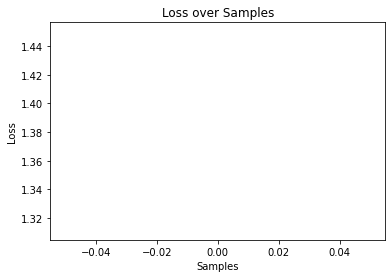

In [15]:
plt.plot(his)
plt.title("Loss over Samples")
plt.xlabel("Samples")
plt.ylabel("Loss")

# Load trained model

In [17]:
"""
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

dataset = MusicDataset_polyphonic(PATH_TO_DATA) 

train_dataset, validation_dataset,  = sklearn.model_selection.train_test_split(dataset, test_size=1 - train_ratio,  random_state=10,)
validation_dataset, test_dataset = sklearn.model_selection.train_test_split(validation_dataset, test_size=test_ratio/(test_ratio + validation_ratio),  random_state=10,) 

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
val_dat""aloader = torch.utils.data.DataLoader(validation_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
"""

'\ntrain_ratio = 0.8\nvalidation_ratio = 0.1\ntest_ratio = 0.1\n\ndataset = MusicDataset_polyphonic(PATH_TO_DATA) \n\ntrain_dataset, validation_dataset,  = sklearn.model_selection.train_test_split(dataset, test_size=1 - train_ratio,  random_state=10,)\nvalidation_dataset, test_dataset = sklearn.model_selection.train_test_split(validation_dataset, test_size=test_ratio/(test_ratio + validation_ratio),  random_state=10,) \n\ntrain_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)\nval_dat""aloader = torch.utils.data.DataLoader(validation_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)\ntest_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)\n'

In [18]:
"""
dataset = MusicDataset_polyphonic(PATH_TO_DATA) 
train_dataset, validation_dataset = sklearn.model_selection.train_test_split(dataset, test_size=0.15, random_state=10,)
#train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(validation_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)

train_dataset = MusicDataset_polyphonic(PATH_TO_DATA) 
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)

val_dataloader,len(val_dataloader)
"""

'\ndataset = MusicDataset_polyphonic(PATH_TO_DATA) \ntrain_dataset, validation_dataset = sklearn.model_selection.train_test_split(dataset, test_size=0.15, random_state=10,)\n#train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)\nval_dataloader = torch.utils.data.DataLoader(validation_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)\n\ntrain_dataset = MusicDataset_polyphonic(PATH_TO_DATA) \ntrain_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)\n\nval_dataloader,len(val_dataloader)\n'

In [19]:
%%capture  
output_dim = 88
model = MusicNetwork(network_type, output_dim, hidden_dim, rnn_depth, cell_type)  
checkpoint = torch.load("./AI-MA_project/model_temp_epoch5.pkl")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Create dic with key:filename, val: part_obj  

In [20]:
#%%capture

path_parts = "AI-MA_project/polyphonic_new"
part_dic = {}

#### create a list with all filenames in the right order ####
file_names_part = []

for filename in sorted(os.listdir(path_parts)):
    if not filename.endswith('.mid'): continue
    file_names_part.append(filename[9:12])
print(file_names_part)

['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145'

# Compute polyphonic accuracy

## long code 

In [21]:
def evaluate_accuracy_polyphonic_separate(model, train_dataloader, part_dic,print_predictions=False):
    
    unitl_len_idx = max_len_load

    path_parts = "AI-MA_project/polyphonic_new"
    acc_score_dict = {'0': [], '1': [], '2': [], '3': [] }
    acc_score_dict_new = {'0': [], '1': [], '2': [], '3': [] }
    acc_score_dict_two = {'0': [], '1': [] }
    for idx, (voices, lens, nbr_voices, file_name) in enumerate(train_dataloader):
        #print("nbr_voices:",nbr_voices)
        #if idx >13:
        #if idx not in [3, 14, 20, 21, 23, 31, 34, 35, 41, 44, 45]:   
            print("idx:",idx)
            if nbr_voices == 4:
                file_name = file_name[0]
                filename_part = os.path.join(path_parts, "part_file" + file_name + ".mid")
                part = partitura.load_score_midi(filename_part)

                part_0 = part[0]
                part_1 = part[1]
                part_2 = part[2]
                part_3 = part[3]
                
                note_array_0 = partitura.utils.note_array_from_part(part_0)
                note_array_1 = partitura.utils.note_array_from_part(part_1)              
                note_array_2 = partitura.utils.note_array_from_part(part_2)
                note_array_3 = partitura.utils.note_array_from_part(part_3)

                list_of_note_arrays = [note_array_0,note_array_1,note_array_2,note_array_3]
                
                ground_truth_label_list = [0,1,2,3]    
                total_predictions_dict = {'0': [], '1': [], '2': [], '3': [] }
                total_truth_dict = {'0': [], '1': [], '2': [], '3': [] }

                #print("type",note_array_0["onset_beat"].shape)
                #print("min onset 0",np.min(note_array_0["onset_beat"]))
                #print("min onset 1",np.min(note_array_1["onset_beat"]))
                #print("min onset 2",np.min(note_array_2["onset_beat"]))
                #print("min onset 3",np.min(note_array_3["onset_beat"]))
                
                minimal_onset = np.min([np.min(note_array_0["onset_beat"]),np.min(note_array_1["onset_beat"]),np.min(note_array_2["onset_beat"]),np.min(note_array_3["onset_beat"]) ])
                
                #print("minimal_onset",minimal_onset)

                for el_note_arr, note_array in enumerate(list_of_note_arrays):

                    onset_beat = 12 * (note_array["onset_beat"] - minimal_onset)
                    note_idx_start = [np.round(num).astype(int) for num in onset_beat]

                    duration_beat = 12 * note_array["duration_beat"]
                    note_idx_duration = [np.clip(np.round(num).astype(int),a_max=None,a_min=1) for num in duration_beat]
                    
                    pitch_list = note_array["pitch"]
                    pitch_list = pitch_list - 21             

                    note_idx_end = np.array(note_idx_start) + np.array(note_idx_duration)

  

                    # do model prediction
                    model.eval()
                    voices = voices.to(device).float()
                    monophonic=True
                    with torch.no_grad():
                        #prediction, prediction_clf = model.predict(voices[:,:,:,-1], lens, monophonic) 
                        prediction = model.predict(voices[:,:,:,-1], lens, monophonic)  
                        label = ground_truth_label_list[el_note_arr]
                        #print("prediction number of voices:",prediction_clf+1)
                    for i in range(len(note_idx_start)):

                        start_first = note_idx_start[i]
                        end_first =  note_idx_end[i]   
                        
                        
                        if start_first == end_first:          
                          print("start_first:",start_first,note_array[i]["onset_beat"])
                          print("duration ",note_array[i]["duration_beat"])

                          print("no round first:",int(12*note_array[i]["onset_beat"]))
                          print("no round second:",int(12*(note_array[i]["onset_beat"]+note_array[i]["duration_beat"] )))
                          print("round first:",np.floor(12*note_array[i]["onset_beat"]))
                          print("round second:",np.floor(12*(note_array[i]["onset_beat"]+note_array[i]["duration_beat"] )))
                          #print("note_array",note_array[i])
                          print(note_array.dtype.names)
                        
                        
                      
                        if start_first < end_first:
                          if end_first <= unitl_len_idx:
                            pitch_first = pitch_list[i]
                            pred_list_first = prediction[start_first:end_first,pitch_first]
                            truth_list = [label for i in range(len(pred_list_first))]
                
                            result = all(elem == pred_list_first[0] for elem in pred_list_first)
                            # do majority vote if not all predictions are for same voice
                            if result == False:
                                major, major_idx = torch.mode(pred_list_first,0)
                                major = major.numpy().tolist()
                                pred_list_first = [major for i in pred_list_first]

                          total_predictions_dict[str(label)].append(pred_list_first)
                          total_truth_dict[str(label)].append(truth_list)

                          if len(pred_list_first)==0:
                            print("ATTENTION:", len(pred_list_first),str(label) )
                            print("index:", idx)
                            print("------------------------------------------------------------------------")

                if print_predictions == True:
                    #################### print pr ####################
                    fig_size_1 = (20, 10)

                    prediction_0 = np.where(prediction ==0, 1, 0)
                    prediction_1 = np.where(prediction ==1, 1, 0)
                    prediction_2 = np.where(prediction ==2, 1, 0)
                    prediction_3 = np.where(prediction ==3, 1, 0)

                    ####### print predicte pr #######                  
                    colors_0 = 'black red'.split()
                    colors_1 = 'none green'.split()  
                    colors_2 = 'none blue'.split() 
                    colors_3 = 'none orange'.split()                
                    cmap_0 = matplotlib.colors.ListedColormap(colors_0, name='colors', N=None)        
                    cmap_1 = matplotlib.colors.ListedColormap(colors_1, name='colors', N=None)
                    cmap_2 = matplotlib.colors.ListedColormap(colors_2, name='colors', N=None)
                    cmap_3 = matplotlib.colors.ListedColormap(colors_3, name='colors', N=None)

                    fig, ax = plt.subplots(1, figsize=fig_size_1)

                    #ax.imshow(prediction_0.T[:,2000:2200], origin="lower", cmap=cmap_0, interpolation='nearest', aspect='auto') 
                    #ax.imshow(prediction_1.T[:,2000:2200], origin="lower", cmap=cmap_1, interpolation='nearest', aspect='auto')   
                    #ax.imshow(prediction_2.T[:,2000:2200], origin="lower", cmap=cmap_2, interpolation='nearest', aspect='auto')
                    #ax.imshow(prediction_3.T[:,2000:2200], origin="lower", cmap=cmap_3, interpolation='nearest', aspect='auto')
                    
                    ax.imshow(prediction_0.T, origin="lower", cmap=cmap_0, interpolation='nearest', aspect='auto') 
                    ax.imshow(prediction_1.T, origin="lower", cmap=cmap_1, interpolation='nearest', aspect='auto')   
                    ax.imshow(prediction_2.T, origin="lower", cmap=cmap_2, interpolation='nearest', aspect='auto')
                    ax.imshow(prediction_3.T, origin="lower", cmap=cmap_3, interpolation='nearest', aspect='auto')

                    ax.set_title("PREDICTED: red-v0, green-v1, blue-v2, orange-v3")                
                    ax.set_xlabel(f'Time ({"beat"}s/{12})')
                    ax.set_ylabel('Piano key')
                    plt.show()

                    ####### print original pr #######
                    onset_beat = partitura.utils.ensure_notearray(part)['onset_beat'][-1]
                    duration_beat = partitura.utils.ensure_notearray(part)['duration_beat'][-1]
                    beat_all = onset_beat + duration_beat
                    pr_zero = partitura.utils.compute_pianoroll(part_0, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
                    pr_zero = pr_zero.toarray()
                    pr_one = partitura.utils.compute_pianoroll(part_1, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
                    pr_one = pr_one.toarray()
                    pr_two = partitura.utils.compute_pianoroll(part_2, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
                    pr_two = pr_two.toarray()
                    pr_three = partitura.utils.compute_pianoroll(part_3, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
                    pr_three = pr_three.toarray()

                    fig, ax = plt.subplots(1, figsize=fig_size_1)
                    #ax.imshow(pr_zero[:,2000:2200], origin="lower", cmap=cmap_0, interpolation='nearest', aspect='auto')
                    #ax.imshow(pr_one[:,2000:2200], origin="lower", cmap=cmap_1, interpolation='nearest', aspect='auto')
                    #ax.imshow(pr_two[:,2000:2200], origin="lower", cmap=cmap_2, interpolation='nearest', aspect='auto')
                    #ax.imshow(pr_three[:,2000:2200], origin="lower", cmap=cmap_3, interpolation='nearest', aspect='auto')

                    ax.imshow(pr_zero[:,:unitl_len_idx], origin="lower", cmap=cmap_0, interpolation='nearest', aspect='auto')
                    ax.imshow(pr_one[:,:unitl_len_idx], origin="lower", cmap=cmap_1, interpolation='nearest', aspect='auto')
                    ax.imshow(pr_two[:,:unitl_len_idx], origin="lower", cmap=cmap_2, interpolation='nearest', aspect='auto')
                    ax.imshow(pr_three[:,:unitl_len_idx], origin="lower", cmap=cmap_3, interpolation='nearest', aspect='auto')
                    
                    
                        
                    ax.set_title("ORIGINAL: red-v0, green-v1 ,blue-v2, orange-v3")                
                    ax.set_xlabel(f'Time ({"beat"}s/{12})')
                    ax.set_ylabel('Piano key' )
                    plt.show()

                
                count_dict_2 = {'0': [], '1': [], '2': [], '3': [] }
                for gt, i in enumerate(total_predictions_dict.keys()):
                    counting = 0
                    for j in range(len(total_predictions_dict[i])):
                        if total_predictions_dict[i][j][0] == gt:         
                            counting +=1
                    count_dict_2[i].append(counting)

                acc_0 = count_dict_2["0"][0]/len(total_predictions_dict["0"])
                acc_1 = count_dict_2["1"][0]/len(total_predictions_dict["1"])
                acc_2 = count_dict_2["2"][0]/len(total_predictions_dict["2"])
                acc_3 = count_dict_2["3"][0]/len(total_predictions_dict["3"])
                
                
                ########## COMPARE HERE EACH PREDICTION ALWAYS WITH ALL VOICES !!!   ##########
                count_dict_2 = {'0': [], '1': [], '2': [], '3': [] }
                intermed_dict = {'0': [], '1': [], '2': [], '3': [] }

                for gt, i in enumerate(total_predictions_dict.keys()):
                  intermed_dict = {'0': [], '1': [], '2': [], '3': [] } 
                  for j in range(len(total_predictions_dict[i])):
                    for idx_tr, tr in enumerate([0,1,2,3]):
                      if total_predictions_dict[i][j][0] == tr:
                        intermed_dict[list(intermed_dict.keys())[idx_tr]].append(1)
                  sum_0 = np.array([intermed_dict["0"]]).sum()
                  sum_1 = np.array([intermed_dict["1"]]).sum()
                  sum_2 = np.array([intermed_dict["2"]]).sum()
                  sum_3 = np.array([intermed_dict["3"]]).sum()
                  count_dict_2[list(count_dict_2.keys())[gt]] = intermed_dict


                hit_list_0 = [np.array([count_dict_2["0"]["0"]]).sum(),np.array([count_dict_2["0"]["1"]]).sum(),np.array([count_dict_2["0"]["2"]]).sum(),np.array([count_dict_2["0"]["3"]]).sum() ]
                hit_list_1 = [np.array([count_dict_2["1"]["0"]]).sum(),np.array([count_dict_2["1"]["1"]]).sum(),np.array([count_dict_2["1"]["2"]]).sum(),np.array([count_dict_2["1"]["3"]]).sum() ]
                hit_list_2 = [np.array([count_dict_2["2"]["0"]]).sum(),np.array([count_dict_2["2"]["1"]]).sum(),np.array([count_dict_2["2"]["2"]]).sum(),np.array([count_dict_2["2"]["3"]]).sum() ]
                hit_list_3 = [np.array([count_dict_2["3"]["0"]]).sum(),np.array([count_dict_2["3"]["1"]]).sum(),np.array([count_dict_2["3"]["2"]]).sum(),np.array([count_dict_2["3"]["3"]]).sum() ]  

                hit_list_temp_0 = hit_list_0.copy()
                hit_list_temp_1 = hit_list_1.copy()
                hit_list_temp_2 = hit_list_2.copy()
                hit_list_temp_3 = hit_list_3.copy()
                
                old_max_hist_list = [hit_list_0, hit_list_1, hit_list_2, hit_list_3]

                for i in range(4):
                    max_0 = np.max(hit_list_temp_0)
                    max_idx_0 = np.argmax(hit_list_temp_0)
                    max_1 = np.max(hit_list_temp_1)
                    max_idx_1 = np.argmax(hit_list_temp_1)
                    max_2 = np.max(hit_list_temp_2)
                    max_idx_2 = np.argmax(hit_list_temp_2)
                    max_3 = np.max(hit_list_temp_3)
                    max_idx_3 = np.argmax(hit_list_temp_3)

                    max_list = [max_0, max_1, max_2, max_3]
                    max_idx_list = [max_idx_0, max_idx_1, max_idx_2, max_idx_3]
                    max_hit_list = [hit_list_temp_0, hit_list_temp_1, hit_list_temp_2, hit_list_temp_3]

                    sorted_idx_max_list = np.argsort(max_list)

                    max_value_max_list = max_list[sorted_idx_max_list[-1]]
                    max_value_max_idx_list = sorted_idx_max_list[-1]

                    biggest_list = old_max_hist_list[max_value_max_idx_list]
                    max_prediction_idx = biggest_list.index(max_value_max_list)


                    biggest_list_new = max_hit_list[max_value_max_idx_list]
                    max_prediction_idx_new = biggest_list_new.index(max_value_max_list)

                    max_pred_acc = max_value_max_list/len(total_predictions_dict[list(total_predictions_dict.keys())[max_value_max_idx_list]])
                    print("maximal overlap between gt voice {} and pred {}, ACC {}:".format(max_value_max_idx_list, max_prediction_idx, max_pred_acc))

                    hit_list_temp_0.pop(max_prediction_idx_new)
                    hit_list_temp_1.pop(max_prediction_idx_new)
                    hit_list_temp_2.pop(max_prediction_idx_new)
                    hit_list_temp_3.pop(max_prediction_idx_new)

                    acc_score_dict_new[list(acc_score_dict_new.keys())[max_value_max_idx_list]].append(max_pred_acc)


                
                print("acc 0, sample {}:".format(idx),acc_0)
                print("acc 1, sample {}:".format(idx),acc_1)
                print("acc 2, sample {}:".format(idx),acc_2)
                print("acc 3, sample {}:".format(idx),acc_3)

                acc_score_dict["0"].append(acc_0)
                acc_score_dict["1"].append(acc_1)
                acc_score_dict["2"].append(acc_2)
                acc_score_dict["3"].append(acc_3)



            if nbr_voices == 2:
                file_name = file_name[0]
                filename_part = os.path.join(path_parts, "part_file" + file_name + ".mid")
                part = partitura.load_score_midi(filename_part)

                part_0 = part[0]
                part_1 = part[1]
                
                note_array_0 = partitura.utils.note_array_from_part(part_0)
                note_array_1 = partitura.utils.note_array_from_part(part_1)
                
                list_of_note_arrays_2 = [note_array_0,note_array_1]

                
                ground_truth_label_list_2 = [0,1]              
                total_predictions_dict_2 = {'0': [], '1': [] }
                total_truth_dict_2 = {'0': [], '1': [] }
                
                minimal_onset = np.min([np.min(note_array_0["onset_beat"]),np.min(note_array_1["onset_beat"]) ])


                for el_note_arr, note_array in enumerate(list_of_note_arrays_2):

                    onset_beat = 12 * (note_array["onset_beat"] - minimal_onset)
                    note_idx_start = [np.round(num).astype(int) for num in onset_beat]

                    duration_beat = 12 * note_array["duration_beat"]
                    note_idx_duration = [np.clip(np.round(num).astype(int),a_max=None,a_min=1) for num in duration_beat]
                    
                    pitch_list = note_array["pitch"]
                    pitch_list = pitch_list - 21             

                    note_idx_end = np.array(note_idx_start) + np.array(note_idx_duration)
                

                    # do model prediction
                    model.eval()
                    voices = voices.to(device).float()
                    monophonic=True
                    with torch.no_grad():
                        #prediction, prediction_clf = model.predict(voices[:,:,:,-1], lens, monophonic)
                        prediction = model.predict(voices[:,:,:,-1], lens, monophonic)   
                        label = ground_truth_label_list_2[el_note_arr]
                        #print("prediction number of voices:",prediction_clf+1)

                    for i in range(len(note_idx_start)):
                        start_first = note_idx_start[i]
                        end_first =  note_idx_end[i]   

                        if start_first == end_first:          

                          print("start_first:",start_first,note_array[i]["onset_beat"])
                          print("duration ",note_array[i]["duration_beat"])

                          print("no round first:",int(12*note_array[i]["onset_beat"]))
                          print("no round second:",int(12*(note_array[i]["onset_beat"]+note_array[i]["duration_beat"] )))
                          print("round first:",int(np.floor(12*note_array[i]["onset_beat"])))
                          print("round second:",int(np.ceil(12*(note_array[i]["onset_beat"]+note_array[i]["duration_beat"] ))))
                          print("note_array",note_array[i])
                          print(note_array.dtype.names)
                        



                        if start_first < end_first:

                          if end_first <= unitl_len_idx:
                            pitch_first = pitch_list[i]
                            
                            pred_list_first = prediction[start_first:end_first,pitch_first]
                            truth_list = [label for i in range(len(pred_list_first))]
                
                            result = all(elem == pred_list_first[0] for elem in pred_list_first)
                            # do majority vote if not all predictions are for same voice
                            if result == False:
                                major, major_idx = torch.mode(pred_list_first,0)
                                major = major.numpy().tolist()
                                pred_list_first = [major for i in pred_list_first]

                          total_predictions_dict_2[str(label)].append(pred_list_first)
                          total_truth_dict_2[str(label)].append(truth_list)

                          if len(pred_list_first)==0:
                            print("ATTENTION:", len(pred_list_first),str(label) )
                            print("index:", idx)
                            print("------------------------------------------------------------------------")
                            print("start_first",start_first)
                            print("end_first",end_first)
                            print("pitch_first",pitch_first)
                            print("i",i)
                            print("onset_beat",note_idx_start)
                            print("duration_beat",note_idx_end)


                        


                if print_predictions == True:
                    #################### print pr ####################
                    fig_size_1 = (20, 10)
                    prediction_0 = np.where(prediction ==0, 1, 0)
                    prediction_1 = np.where(prediction ==1, 1, 0)
                    prediction_2 = np.where(prediction ==2, 1, 0)
                    prediction_3 = np.where(prediction ==3, 1, 0)

                    ####### print predicte pr #######                  
                    colors_0 = 'black red'.split()
                    colors_1 = 'none green'.split()  
                    colors_2 = 'none blue'.split() 
                    colors_3 = 'none orange'.split()                
                    cmap_0 = matplotlib.colors.ListedColormap(colors_0, name='colors', N=None)        
                    cmap_1 = matplotlib.colors.ListedColormap(colors_1, name='colors', N=None)
                    cmap_2 = matplotlib.colors.ListedColormap(colors_2, name='colors', N=None)
                    cmap_3 = matplotlib.colors.ListedColormap(colors_3, name='colors', N=None)

                    fig, ax = plt.subplots(1, figsize=fig_size_1)

                    ax.imshow(prediction_0.T, origin="lower", cmap=cmap_0, interpolation='nearest', aspect='auto') 
                    ax.imshow(prediction_1.T, origin="lower", cmap=cmap_1, interpolation='nearest', aspect='auto')   
                    ax.imshow(prediction_2.T, origin="lower", cmap=cmap_2, interpolation='nearest', aspect='auto')
                    ax.imshow(prediction_3.T, origin="lower", cmap=cmap_3, interpolation='nearest', aspect='auto')
                    ax.set_title("PREDICTED: 2 piece red-v0, green-v1, blue-v2, orange-v3")                
                    ax.set_xlabel(f'Time ({"beat"}s/{12})')
                    ax.set_ylabel('Piano key')
                    plt.show()


                    ####### print original pr #######
                    onset_beat = partitura.utils.ensure_notearray(part)['onset_beat'][-1]
                    duration_beat = partitura.utils.ensure_notearray(part)['duration_beat'][-1]
                    beat_all = onset_beat + duration_beat
                    pr_zero = partitura.utils.compute_pianoroll(part_0, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
                    pr_zero = pr_zero.toarray()
                    pr_one = partitura.utils.compute_pianoroll(part_1, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
                    pr_one = pr_one.toarray()

                    fig, ax = plt.subplots(1, figsize=fig_size_1)
                    ax.imshow(pr_zero[:,:unitl_len_idx], origin="lower", cmap=cmap_0, interpolation='nearest', aspect='auto')
                    ax.imshow(pr_one[:,:unitl_len_idx], origin="lower", cmap=cmap_1, interpolation='nearest', aspect='auto') 
                    ax.set_title("ORIGINAL: 2 piece red-v0, green-v1")                
                    ax.set_xlabel(f'Time ({"beat"}s/{12})')
                    ax.set_ylabel('Piano key')
                    plt.show()


                ########## COMPARE HERE EACH PREDICTION ALWAYS WITH ALL VOICES !!!   ##########
                count_dict_22 = {'0': [], '1': [] }
                intermed_dict = {'0': [], '1': [], '2': [], '3': [] }

                for gt, i in enumerate(total_predictions_dict_2.keys()):
                  intermed_dict = {'0': [], '1': [], '2': [], '3': [] } 
                  for j in range(len(total_predictions_dict_2[i])):
                    for idx_tr, tr in enumerate([0,1,2,3]):
                      if total_predictions_dict_2[i][j][0] == tr:
                        intermed_dict[list(intermed_dict.keys())[idx_tr]].append(1)
                  sum_0 = np.array([intermed_dict["0"]]).sum()
                  sum_1 = np.array([intermed_dict["1"]]).sum()
                  sum_2 = np.array([intermed_dict["2"]]).sum()
                  sum_3 = np.array([intermed_dict["3"]]).sum()
                  count_dict_22[list(count_dict_22.keys())[gt]] = intermed_dict

               
                hit_list_0 = [np.array([count_dict_22["0"]["0"]]).sum(),np.array([count_dict_22["0"]["1"]]).sum(),np.array([count_dict_22["0"]["2"]]).sum(),np.array([count_dict_22["0"]["3"]]).sum() ]
                hit_list_1 = [np.array([count_dict_22["1"]["0"]]).sum(),np.array([count_dict_22["1"]["1"]]).sum(),np.array([count_dict_22["1"]["2"]]).sum(),np.array([count_dict_22["1"]["3"]]).sum() ]            
                hit_list_temp_0 = hit_list_0.copy()
                hit_list_temp_1 = hit_list_1.copy()
                old_max_hist_list = [hit_list_0, hit_list_1]


                for i in range(2):
                    max_0 = np.max(hit_list_temp_0)
                    max_idx_0 = np.argmax(hit_list_temp_0)
                    max_1 = np.max(hit_list_temp_1)
                    max_idx_1 = np.argmax(hit_list_temp_1)

                    max_list = [max_0, max_1]
                    max_idx_list = [max_idx_0, max_idx_1]
                    max_hit_list = [hit_list_temp_0, hit_list_temp_1]
                    sorted_idx_max_list = np.argsort(max_list)

                    max_value_max_list = max_list[sorted_idx_max_list[-1]]
                    max_value_max_idx_list = sorted_idx_max_list[-1]

                    biggest_list = old_max_hist_list[max_value_max_idx_list]
                    max_prediction_idx = biggest_list.index(max_value_max_list)

                    biggest_list_new = max_hit_list[max_value_max_idx_list]
                    max_prediction_idx_new = biggest_list_new.index(max_value_max_list)

                    max_pred_acc = max_value_max_list/len(total_predictions_dict_2[list(total_predictions_dict_2.keys())[max_value_max_idx_list]])
                    print("maximal overlap between gt voice {} and pred {}, ACC {}:".format(max_value_max_idx_list, max_prediction_idx, max_pred_acc))

                    hit_list_temp_0.pop(max_prediction_idx_new)
                    hit_list_temp_1.pop(max_prediction_idx_new)


                    acc_score_dict_two[list(acc_score_dict_two.keys())[max_value_max_idx_list]].append(max_pred_acc)


                
    #return statistics.mean(acc_score_dict_new["0"]), statistics.mean(acc_score_dict_new["1"]), statistics.mean(acc_score_dict_new["2"]), statistics.mean(acc_score_dict_new["3"]), total_predictions_dict, total_truth_dict, statistics.mean(acc_score_dict_two["0"]), statistics.mean(acc_score_dict_two["1"]), statistics.mean(acc_score_dict["0"]), statistics.mean(acc_score_dict["1"]), statistics.mean(acc_score_dict["2"]),statistics.mean(acc_score_dict["3"])
    return statistics.mean(acc_score_dict_new["0"]), statistics.mean(acc_score_dict_new["1"]), statistics.mean(acc_score_dict_new["2"]), statistics.mean(acc_score_dict_new["3"]), total_predictions_dict, total_truth_dict, statistics.mean(acc_score_dict_two["0"]), statistics.mean(acc_score_dict_two["1"])#, statistics.mean(acc_score_dict["0"]), statistics.mean(acc_score_dict["1"]), statistics.mean(acc_score_dict["2"]),statistics.mean(acc_score_dict["3"])

## evaluate

idx: 0


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=69 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_on channel=0 note=0 velocity=0 time=119
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=33 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:419: UserWarning: pitch spelling
  warnings.warn("pitch spelling")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:273: UserWarning: voice estimation
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:489: UserWarning: create_part
  part_name=part_names.get(part_nr, None),
/usr/local/lib/python3.7/di

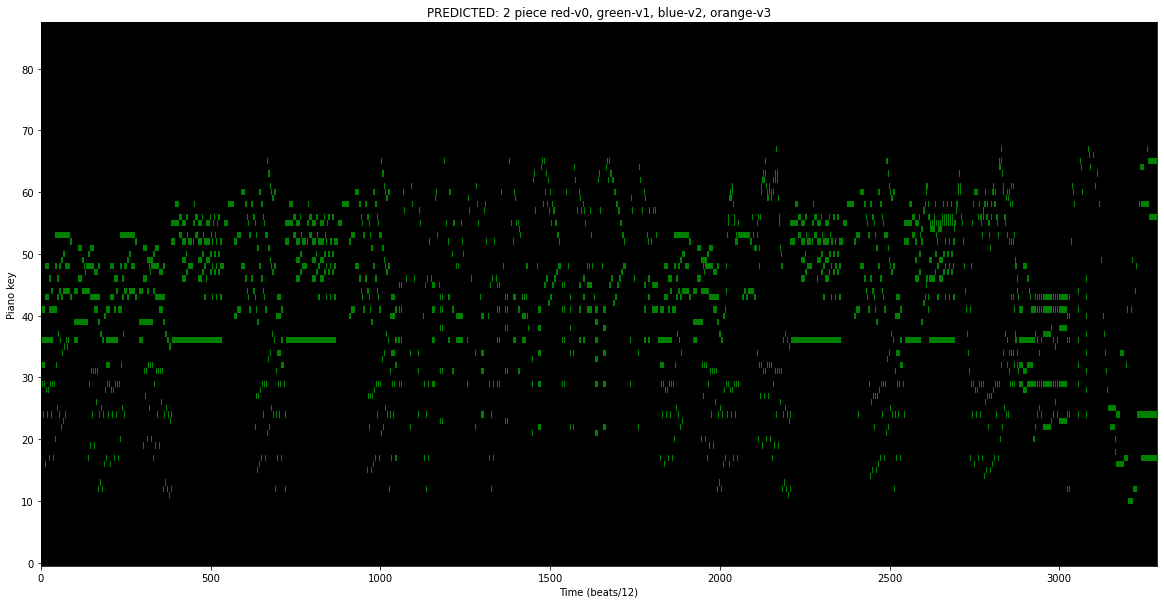

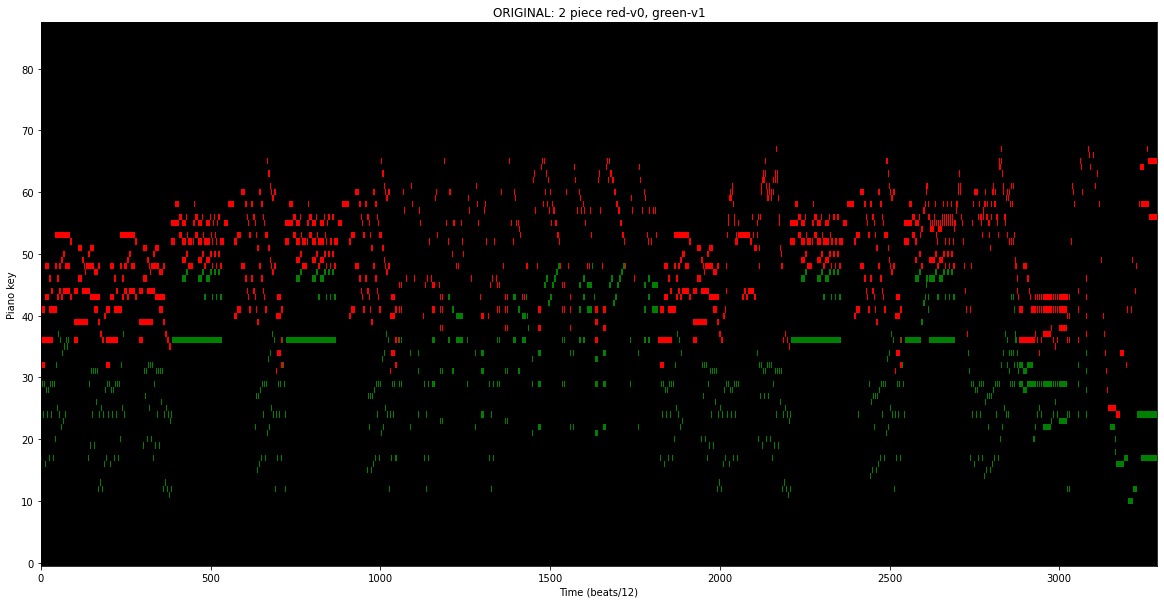

maximal overlap between gt voice 0 and pred 1, ACC 0.994269340974212:
maximal overlap between gt voice 1 and pred 0, ACC 0.0:
idx: 1


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_on channel=0 note=0 velocity=0 time=299
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: voice estimation


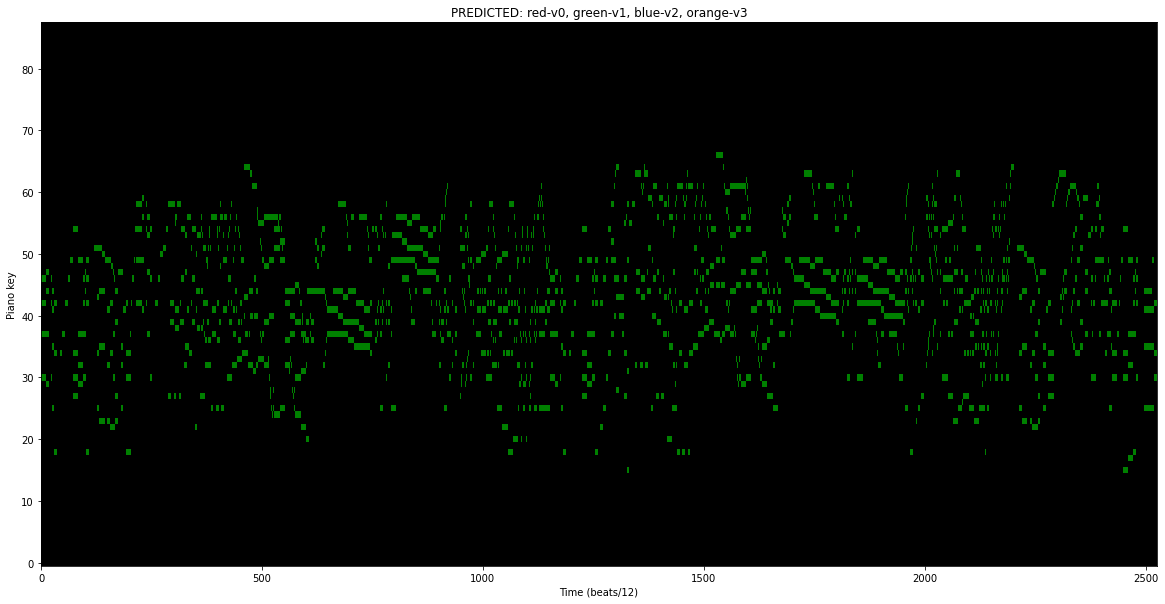

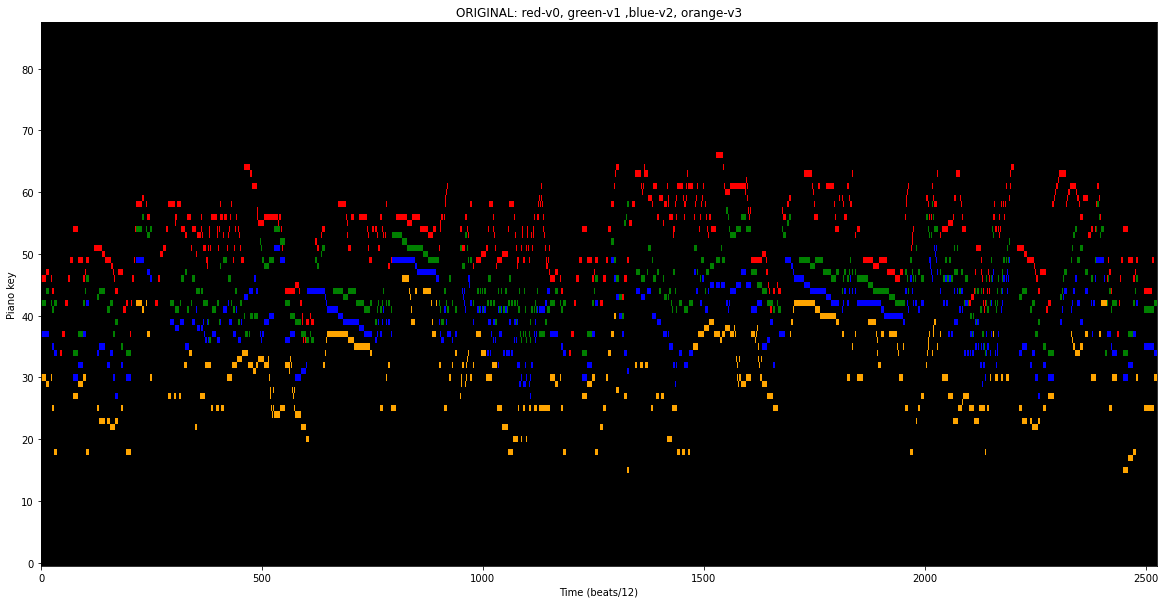

maximal overlap between gt voice 2 and pred 1, ACC 1.0:
maximal overlap between gt voice 3 and pred 0, ACC 0.0:
maximal overlap between gt voice 3 and pred 0, ACC 0.0:
maximal overlap between gt voice 3 and pred 0, ACC 0.0:
acc 0, sample 1: 0.0
acc 1, sample 1: 1.0
acc 2, sample 1: 0.0
acc 3, sample 1: 0.0
idx: 2


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=51 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)


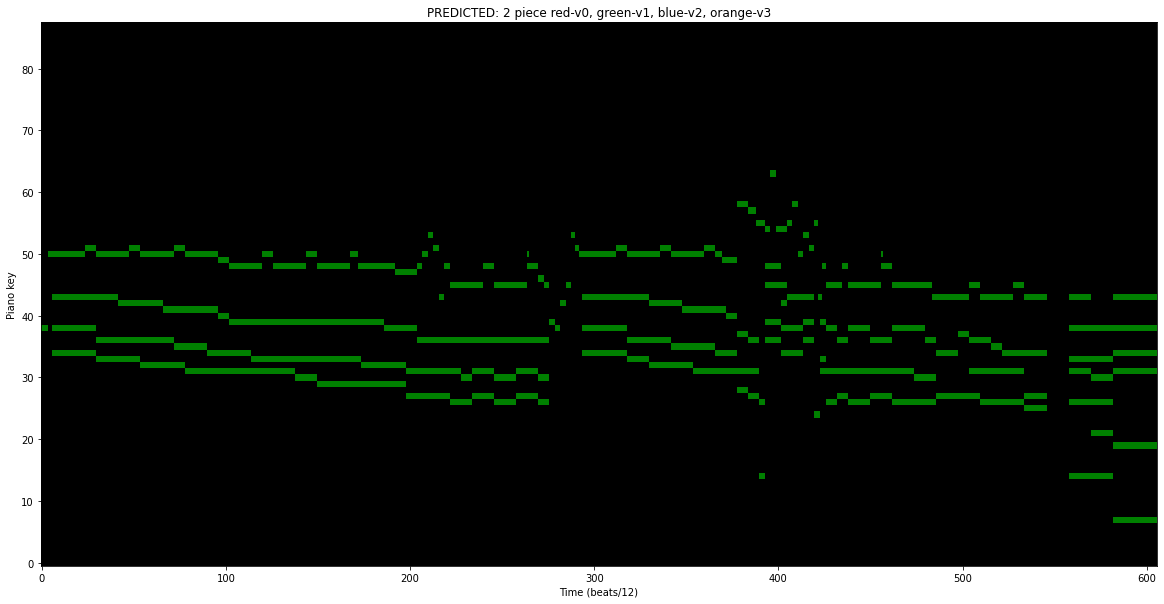

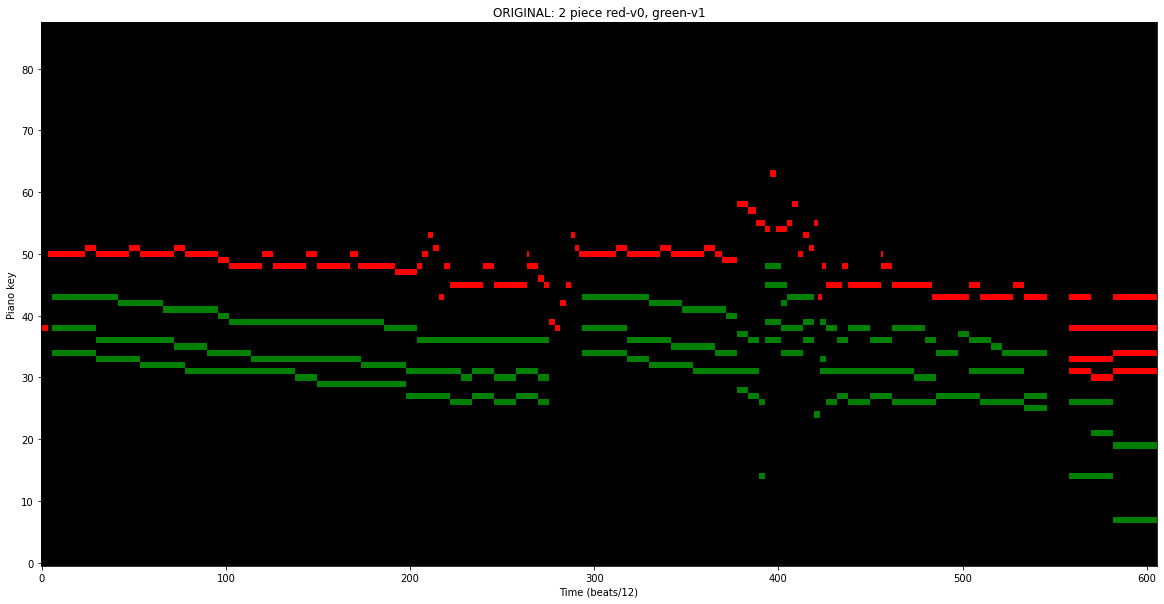

maximal overlap between gt voice 1 and pred 1, ACC 1.0:
maximal overlap between gt voice 1 and pred 0, ACC 0.0:
idx: 3


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=67 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_on channel=0 note=0 velocity=0 time=209
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=58 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=62 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=63 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s

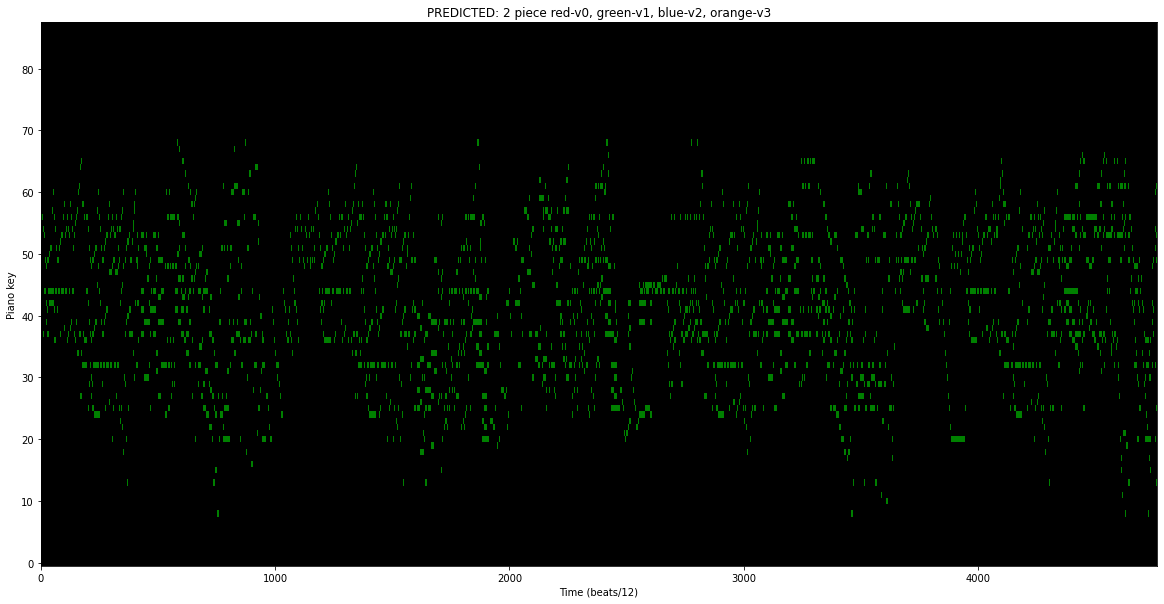

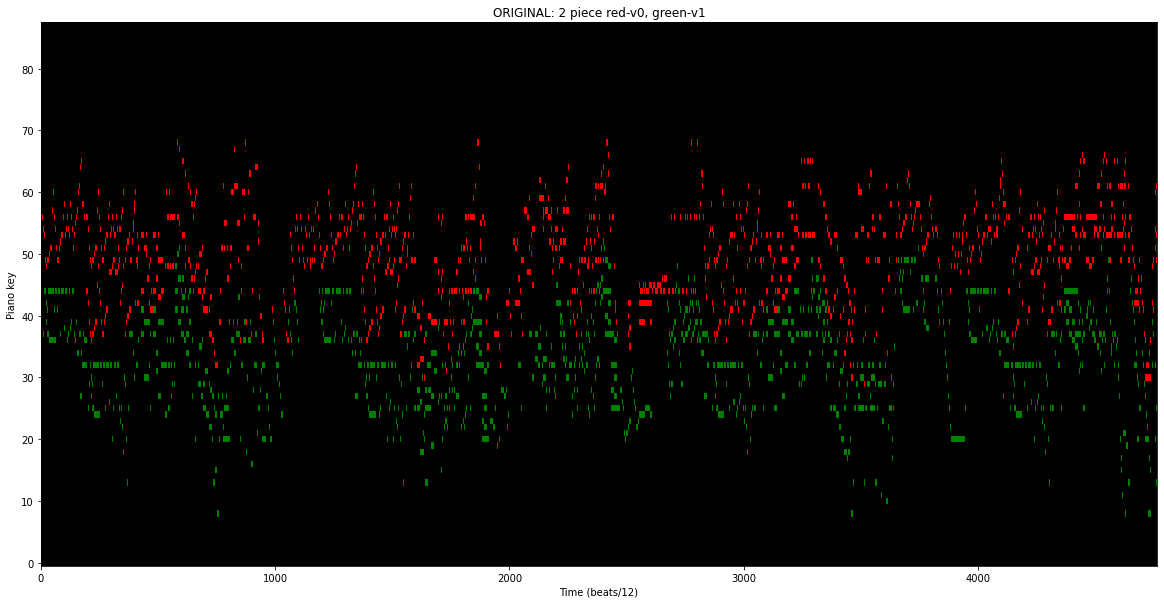

maximal overlap between gt voice 0 and pred 1, ACC 0.994750656167979:
maximal overlap between gt voice 1 and pred 0, ACC 0.0:
idx: 4


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=67 velocity=83 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=96 velocity=64 time=28
  warnings.warn("ignoring MIDI message %s" % msg)


KeyboardInterrupt: ignored

In [23]:
#acc_0_new, acc_1_new, acc_2_new, acc_3_new, dict_pred , dict_gt, acc_0_2, acc_1_2, acc_0 , acc_1, acc_2, acc_3 = evaluate_accuracy_polyphonic_separate(model,val_dataloader,part_dic=file_names_part,print_predictions=True)
acc_0_new, acc_1_new, acc_2_new, acc_3_new, dict_pred , dict_gt, acc_0_2, acc_1_2 = evaluate_accuracy_polyphonic_separate(model,test_dataloader,part_dic=file_names_part,print_predictions=True)

print("acc_0_2:",acc_0_2)
print("acc_1_2:",acc_1_2)
print("acc_0_new:",acc_0_new)
print("acc_1_new:",acc_1_new)
print("acc_2_new:",acc_2_new)
print("acc_3_new:",acc_3_new)

### save output

In [ ]:
#acc_0_new, acc_1_new, acc_2_new, acc_3_new, dict_pred , dict_gt, acc_0_2, acc_1_2, acc_0 , acc_1, acc_2, acc_3 = evaluate_accuracy_polyphonic_separate(model,val_dataloader,part_dic=file_names_part,print_predictions=True)
acc_0_new, acc_1_new, acc_2_new, acc_3_new, dict_pred , dict_gt, acc_0_2, acc_1_2 = evaluate_accuracy_polyphonic_separate(model,val_dataloader,part_dic=file_names_part,print_predictions=True)

print("acc_0_2:",acc_0_2)
print("acc_1_2:",acc_1_2)
#print("acc_0:",acc_0)
#print("acc_1:",acc_1)
#print("acc_2:",acc_2)
#print("acc_3:",acc_3)
print("acc_0_new:",acc_0_new)
print("acc_1_new:",acc_1_new)
print("acc_2_new:",acc_2_new)
print("acc_3_new:",acc_3_new)

# Accuracy HMM

## calculate mc leod pr helper fct

In [ ]:
def calculate_mcleod_pr (file_name, sentences,nbr_voices):
    path = "AI-MA_project/polyphonic_new"
    fullname = os.path.join(path, "part_file"+ file_name +".mid")


    part = partitura.load_score_midi(fullname)
    onset_beat = partitura.utils.ensure_notearray(part)['onset_beat'][-1]
    duration_beat = partitura.utils.ensure_notearray(part)['duration_beat'][-1]
    beat_all = onset_beat + duration_beat


    ### apply hmms method ### 
    part_hmm = partitura.load_score_midi(fullname,part_voice_assign_mode=2)
    voice_info = partitura.utils.note_array_from_part(part_hmm)["voice"]
    
    ### seperate the results -> e.g. pos_zero = all positions where chew prediction says voice 0 ####
    pos_0 = np.where(voice_info==1)
    pos_1 = np.where(voice_info==2)
    
    if nbr_voices ==4:
        pos_2 = np.where(voice_info==3)
        pos_3 = np.where(voice_info==4)

    note_array_all = partitura.utils.ensure_notearray(part_hmm)

    ### create notearray object that contain only the corresponding voice ###
    note_array_0= partitura.utils.ensure_notearray(part_hmm)[pos_0]
    note_array_1 = partitura.utils.ensure_notearray(part_hmm)[pos_1]
    
    if nbr_voices==4:
        note_array_2 = partitura.utils.ensure_notearray(part_hmm)[pos_2]
        note_array_3 = partitura.utils.ensure_notearray(part_hmm)[pos_3]

    ### create pr representation of all voices ###
    onset_beat_0 = note_array_all['onset_beat'][-1]
    duration_beat_0 = note_array_all['duration_beat'][-1]
    beat_0 = onset_beat_0 + duration_beat_0
    

    pr_zero = partitura.utils.compute_pianoroll(note_array_0, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
    pr_zero = pr_zero.toarray()[:,:max_len_load]

    pr_one = partitura.utils.compute_pianoroll(note_array_1, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
    pr_one = pr_one.toarray()[:,:max_len_load]


    if nbr_voices==4:

        pr_two = partitura.utils.compute_pianoroll(note_array_2, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
        pr_two = pr_two.toarray()[:,:max_len_load]

        pr_three = partitura.utils.compute_pianoroll(note_array_3, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
        pr_three = pr_three.toarray()[:,:max_len_load]
    else:
        pr_two = np.zeros(pr_one.shape)
        pr_three = np.zeros(pr_one.shape)

    scores_comb = np.stack([pr_zero, pr_one, pr_two, pr_three], axis=0)
    scores_comb = np.swapaxes(scores_comb, 1, 2)
    scores_comb = scores_comb[None,:,:,:]
    scores_comb = torch.from_numpy(scores_comb)

    sum_tensor = scores_comb * sentences[:,None,:,:]
    prediction = np.squeeze(sum_tensor.cpu().numpy())                # prediction is of shape 4,T,88 and contains a probability for the result to belong to one of the 4 voices -> taking argmax: gives the voice with the highes probability
    v_pred_argm = torch.tensor(np.argmax(prediction,axis=0)) 
    mask_pred = np.squeeze(sentences)== 0
    v_pred_argm[mask_pred] = -1

    return v_pred_argm 

## evaluate_mc_leod_fugues


In [ ]:
def evaluate_mc_leod_fugues(train_dataloader, part_dic,F1):
    #print("part_dic:",part_dic)

    f_score_dict = {'0': [], '1': [], '2': [], '3': [] }
    acc_score_dict = {'0': [], '1': [] }
    acc_score_dict_four = {'0': [], '1': [], '2': [], '3': [] }

    for idx, (voices, lens, nbr_voices, file_name) in enumerate(train_dataloader):
        if  idx <34 and idx not in [0,1,3,4,9,10,11,12,13,14,16,19,20,21,22,23,24,26,27,31,32,33,34]:

                file_name = file_name[0]
                filename_part = os.path.join(path_parts, "part_file" + file_name + ".mid")
                part = partitura.load_score_midi(filename_part)

                #file_name = file_name[0]
                #part = part_dic[file_name]
                part_0 = part[0]
                part_1 = part[1]
                
                note_array_0 = partitura.utils.note_array_from_part(part_0)
                note_array_1 = partitura.utils.note_array_from_part(part_1)
                
                list_of_note_arrays = [note_array_0,note_array_1]


                if len(part) == 4:
                    part_2 = part[2]
                    note_array_2 = partitura.utils.note_array_from_part(part_2)
                    part_3 = part[3]
                    note_array_3 = partitura.utils.note_array_from_part(part_3)
                    list_of_note_arrays = [note_array_0,note_array_1,note_array_2,note_array_3]

           
                
                ground_truth_label_list = [0,1,2,3]              
                total_predictions_dict = {'0': [], '1': [], '2': [], '3': [] }
                total_truth_dict = {'0': [], '1': [], '2': [], '3': [] }
                accordance_dict = {'0': [], '1': [], '2': [], '3': [] }
          
                for el_note_arr, note_array in enumerate(list_of_note_arrays):                    
                    #### get only indices that are positive
                    onset_beat = note_array["onset_beat"]#[note_array["onset_beat"]>=0]

                    if onset_beat[0] < 0:
                        onset_beat -= onset_beat[0]  ### if 1st value of onset_beat is negative add the value of this entry to the whole entry (therefore -)

                    duration_beat = note_array["duration_beat"]#[note_array["onset_beat"]>=0]
                    
                    pitch_list = note_array["pitch"]#[note_array["onset_beat"]>=0]
                    pitch_list = pitch_list - 21             
                    note_idx_start = 12 * onset_beat
                    note_idx_end = 12 * (onset_beat+duration_beat)


                    ### round every entry up to next integer for the starting idx ###
                    note_idx_start = [int(np.ceil(num)) for num in note_idx_start]                      # do this fur whole np array np.ceil(note_idx_start)
                    ### round every entry down to next integer for the ending idx###
                    note_idx_end = [int(np.floor(num)) for num in note_idx_end]
                    

                    ################################### MODEL PREDICTION ###################################                   
                    prediction = calculate_mcleod_pr(file_name,voices[:,:,:,-1],nbr_voices) 
                    label = ground_truth_label_list[el_note_arr]
                

                    for i in range(len(note_idx_start)):
                        start_first = note_idx_start[i]
                        end_first =  note_idx_end[i]
                        pitch_first = pitch_list[i]
                        pred_list_first = prediction[start_first:end_first,pitch_first]                     ### check if an why this is sometimes empty
                        truth_list = [label for i in range(len(pred_list_first))]

                    
                        result = all(elem == pred_list_first[0] for elem in pred_list_first)
                        # do majority vote if not all predictions are for same voice
                        if result == False:
                            major, major_idx = torch.mode(pred_list_first,0)
                            major = major.numpy().tolist()
                            pred_list_first = [major for i in pred_list_first]
                        
                        total_predictions_dict[str(label)].append(pred_list_first)
                        total_truth_dict[str(label)].append(truth_list)
                        accordance_dict[str(label)].append(0)

                        if len(pred_list_first)==0:
                          print("ATTENTION:", len(pred_list_first),str(label) )
                          print("index:", idx)
                          print("------------------------------------------------------------------------")
                          break

                count_dict_2 = {'0': [], '1': [], '2': [], '3': [] }

                for gt, i in enumerate(total_predictions_dict.keys()):
                    counting = 0
                    ### maybe insert if statement: if list_of_note_arrays == 4 oder sowas 
                    for j in range(len(total_predictions_dict[i])):
                        if total_predictions_dict[i][j][0] == gt:
                            counting +=1  
                    count_dict_2[i].append(counting)

                if len(list_of_note_arrays)==2:
                        acc_0 = count_dict_2["0"][0]/len(total_predictions_dict["0"])
                        acc_1 = count_dict_2["1"][0]/len(total_predictions_dict["1"])
                        
                        print("acc 0, sample {}:".format(idx),acc_0)
                        print("acc 1, sample {}:".format(idx),acc_1)
                        
                        acc_score_dict["0"].append(acc_0)
                        acc_score_dict["1"].append(acc_1)
                

                if len(list_of_note_arrays)==4:
                        acc_0 = count_dict_2["0"][0]/len(total_predictions_dict["0"])
                        print("acc 0, sample {}:".format(idx),acc_0)
                        acc_score_dict_four["0"].append(acc_0)

                        acc_1 = count_dict_2["1"][0]/len(total_predictions_dict["1"])
                        print("acc 1, sample {}:".format(idx),acc_1)
                        acc_score_dict_four["1"].append(acc_1)

                        acc_2 = count_dict_2["2"][0]/len(total_predictions_dict["2"])
                        print("acc 2, sample {}:".format(idx),acc_2)
                        acc_score_dict_four["2"].append(acc_2)

                        acc_3 = count_dict_2["3"][0]/len(total_predictions_dict["3"])
                        print("acc 3, sample {}:".format(idx),acc_3)
                        acc_score_dict_four["3"].append(acc_3)


    print("total_predictions_dict",total_predictions_dict.keys())
    return total_predictions_dict, acc_score_dict, statistics.mean(acc_score_dict["0"]), statistics.mean(acc_score_dict["1"]), statistics.mean(acc_score_dict_four["0"]), statistics.mean(acc_score_dict_four["1"]),statistics.mean(acc_score_dict_four["2"]),statistics.mean(acc_score_dict_four["3"])   

## evaluate


In [ ]:
dict_pred , acc_score_dict, acc_0 , acc_1, acc_0_four, acc_1_four, acc_2_four, acc_3_four = evaluate_mc_leod_fugues(val_dataloader,part_dic=file_names_part,F1=False)
print("accuracy two voice pieces:",acc_0 , acc_1)
print("accuracy four voice pieces:",acc_0_four, acc_1_four, acc_2_four, acc_3_four)

# Accuracy Chew